In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [3]:
import torch
import torch.nn.functional as F
from networks.resnet_big import CEResNet
from networks.vision_trans import CEViT
from networks.lstm_cnn import LSTMCNN
from networks.rec_cnn import RecCNN
from dataset import CANDatasetEnet as CANDataset 
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda")

In [4]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [5]:
can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2
test_dataset = CANDataset(root_dir='../data/can-ml/2017-subaru-forester/preprocessed/size_64_10_baseline/TFRecord_w64_s32/2', window_size=32, is_train=False, transform=can_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [6]:
model = CEResNet(num_classes=10)
# # model = LSTMCNN(num_classes=10)
# # model = RecCNN(num_classes=10)
# model = CEViT(
#     emb_size=256,
#     img_size=64,
#     n_classes=10
# )


# save_path = '../save/CAN-ML_models/BaseLine/BaseLine_CAN-ML_ViT_lr_0.05_decay_0.0001_bsz_128_trial_can_ml_vit_64_2017_v2_cosine_warm'  # 10% data , VIT
save_path = '../save/CAN-ML_models/CE/CE_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_64_trial_can_ml_ce_64_cosine_warm' # 10% data, ResNet50 CE
# save_path = '../save/CAN-ML_models/BaseLine/BaseLine_CAN-ML_rec_cnn_lr_0.05_decay_0.0001_bsz_128_trial_can_ml_rec_cnn_64_cosine_warm' # 10% data, LSTM 
# save_path = '../save/CAN-ML_models/BaseLine/BaseLine_CAN-ML_rec_cnn_lr_0.05_decay_0.0001_bsz_128_trial_can_ml_rec_cnn_64_cosine_warm' # 10% data, RecCNN
ckpt_epoch = 22

model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict, strict=False)


<All keys matched successfully>

In [7]:
import numpy as np
import tqdm
import torch
from sklearn.metrics import accuracy_score, classification_report

total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)

model = model.to(device)
model.eval()

with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        images = images.to(device, non_blocking=True)
        
        outputs = model(images)
        
        _, pred = torch.max(outputs, 1)
        
        pred = pred.cpu().numpy()
        labels = labels.cpu().numpy()
        
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)




100%|██████████| 205/205 [00:31<00:00,  6.57it/s]


In [8]:
accuracy = accuracy_score(total_label, total_pred) 
print("Accuracy:", accuracy)

target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Accuracy: 0.9921419034903681
Classification Report:
               precision    recall  f1-score   support

      Normal     0.9943    0.9963    0.9953     20973
    Combined     0.9751    0.9840    0.9796      1315
         DoS     0.9805    1.0000    0.9901       201
       Fuzzy     1.0000    0.8937    0.9439       254
        Gear     0.8767    0.9387    0.9066       212
    Interval     1.0000    0.9974    0.9987      1909
         RPM     0.9815    0.9298    0.9550       399
       Speed     0.9935    0.9541    0.9734       479
  Standstill     1.0000    1.0000    1.0000       186
  Systematic     0.9615    0.9582    0.9599       287

    accuracy                         0.9921     26215
   macro avg     0.9763    0.9652    0.9702     26215
weighted avg     0.9922    0.9921    0.9921     26215



In [9]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [10]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (14 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [11]:
classes = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
n_classes = len(classes)

In [12]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzy        | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 0.3719       | 1.5970       | 0.0000       | 10.6299      | 6.1321       | 0.2619       | 7.0175       | 4.5929       | 0.0000       | 4.1812      
REC    | 0.9963       | 0.9840       | 1.0000       | 0.8937       | 0.9387       | 0.9974       | 0.9298       | 0.9541       | 1.0000       | 0.9582      
PRE    | 0.9943       | 0.9751       | 0.9805       | 1.0000       | 0.8767       | 1.0000       | 0.9815       | 0.9935       | 1.0000       | 0.9615      
F1     | 0.9953       | 0.9796       | 0.9901       | 0.9439       | 0.9066       | 0.9987       | 0.9550       | 0.9734       | 1.0000       | 0.9599      


In [14]:
confusion_matrix = np.array([
    [20895,    26,     4,     0,    28,     0,     7,     3,     0,    10],
    [   21,  1294,     0,     0,     0,     0,     0,     0,     0,     0],
    [    0,     0,   201,     0,     0,     0,     0,     0,     0,     0],
    [   26,     0,     0,   227,     0,     0,     0,     0,     0,     1],
    [   12,     0,     0,     0,   200,     0,     0,     0,     0,     0],
    [    5,     0,     0,     0,     0,  1904,     0,     0,     0,     0],
    [   23,     5,     0,     0,     0,     0,   371,     0,     0,     0],
    [   20,     2,     0,     0,     0,     0,     0,   457,     0,     0],
    [    5,     0,     0,     0,     0,     0,     0,     0,   186,     0],
    [   12,     0,     0,     0,     0,     0,     0,     0,     0,   275]
])

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    mask = np.zeros_like(cm)
    np.fill_diagonal(mask, 1)
    plt.figure(figsize=(10,8))
    # sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, 
            linewidths=0.5, vmin=0, vmax=2500,)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix - CE Resnet50')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300, bbox_inches="tight", pad_inches=0.5)
    plt.show()

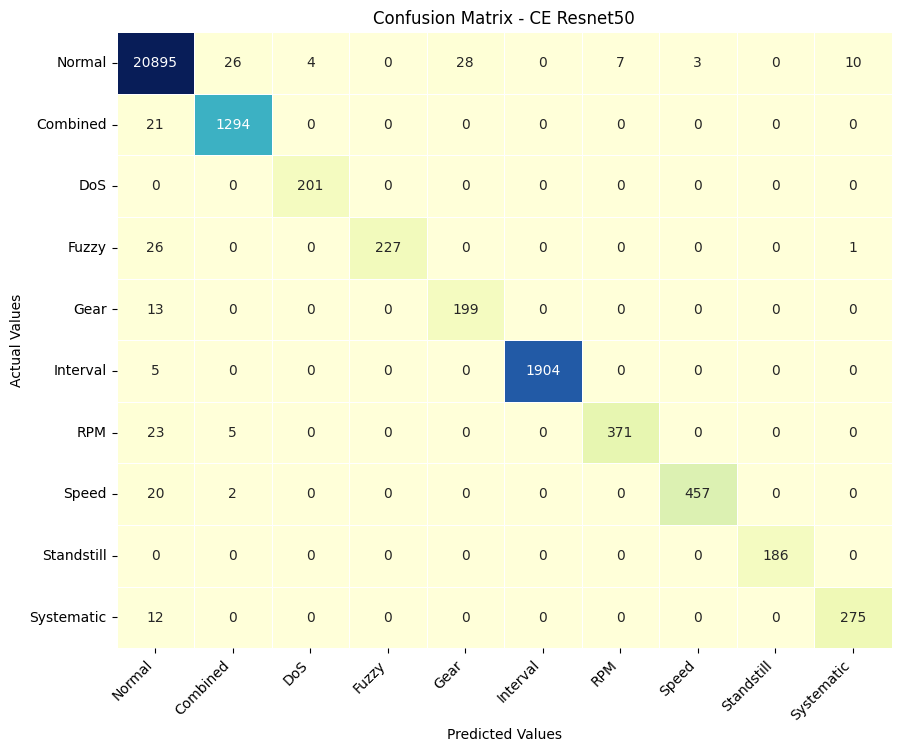

In [16]:
# draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_ViT_transfer_can_ml_{}.png')
draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_CE-Resnet_{}.png')

In [17]:
from sklearn.metrics import classification_report

# Confusion Matrix (cm)
cm = np.array([
    [20854,   41,   0,   5,  10,  16,  16,  14,  1,  16],
    [   68, 1241,  0,   0,   0,   5,   1,   0,  0,  0],
    [    1,    0, 200,  0,   0,   0,   0,   0,  0,  0],
    [   19,    0,  0, 234,  0,   0,   0,   0,  0,  1],
    [   31,    0,  0,   0, 179,  1,   1,   0,  0,  0],
    [   43,    2,  0,   0,   0, 1864, 0,   0,  0,  0],
    [   61,    1,  0,   0,   0,   0, 336,  1,  0,  0],
    [   50,    1,  0,   0,   0,   2,   0, 426, 0,  0],
    [    7,    0,  0,   0,   0,   0,   0,   0, 179, 0],
    [   28,    0,  0,   2,   0,   0,   0,   0,  0, 257]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i][j]
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# Generate classification report
target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: ViT \n", report)


Classification Report: ViT 
               precision    recall  f1-score   support

      Normal     0.9854    0.9943    0.9899     20973
    Combined     0.9650    0.9437    0.9542      1315
         DoS     1.0000    0.9950    0.9975       201
       Fuzzy     0.9710    0.9213    0.9455       254
        Gear     0.9471    0.8443    0.8928       212
    Interval     0.9873    0.9764    0.9818      1909
         RPM     0.9492    0.8421    0.8924       399
       Speed     0.9660    0.8894    0.9261       479
  Standstill     0.9944    0.9624    0.9781       186
  Systematic     0.9380    0.8955    0.9162       287

    accuracy                         0.9830     26215
   macro avg     0.9703    0.9264    0.9475     26215
weighted avg     0.9829    0.9830    0.9828     26215



In [57]:
from sklearn.metrics import classification_report

# Confusion Matrix (cm)
cm = np.array([
    [20928,    15,     0,     6,     4,     2,     8,     5,     1,     4],
    [   37,  1275,     0,     2,     0,     1,     0,     0,     0,     0],
    [    2,     0,   199,     0,     0,     0,     0,     0,     0,     0],
    [   24,     0,     0,   230,     0,     0,     0,     0,     0,     0],
    [   36,     0,     0,     0,   176,     0,     0,     0,     0,     0],
    [   11,     1,     0,     0,     0,  1897,     0,     0,     0,     0],
    [   47,     1,     0,     0,     0,     0,   350,     1,     0,     0],
    [   23,     0,     0,     0,     0,     0,     0,   456,     0,     0],
    [    9,     0,     0,     0,     0,     0,     0,     0,   177,     0],
    [   34,     0,     0,     3,     0,     0,     0,     0,     0,   250]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i][j]
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# Generate classification report
target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: LSTM CNN \n", report)


Classification Report: LSTM CNN 
               precision    recall  f1-score   support

      Normal     0.9895    0.9979    0.9936     20973
    Combined     0.9868    0.9696    0.9781      1315
         DoS     1.0000    0.9900    0.9950       201
       Fuzzy     0.9544    0.9055    0.9293       254
        Gear     0.9778    0.8302    0.8980       212
    Interval     0.9984    0.9937    0.9961      1909
         RPM     0.9777    0.8772    0.9247       399
       Speed     0.9870    0.9520    0.9692       479
  Standstill     0.9944    0.9516    0.9725       186
  Systematic     0.9843    0.8711    0.9242       287

    accuracy                         0.9894     26215
   macro avg     0.9850    0.9339    0.9581     26215
weighted avg     0.9894    0.9894    0.9892     26215



In [58]:
from sklearn.metrics import classification_report

# Confusion Matrix (cm)
cm = np.array([
    [20921,    17,     0,     2,     8,     3,     8,     3,     0,    11],
    [   37,  1276,     0,     0,     0,     0,     2,     0,     0,     0],
    [    4,     0,   197,     0,     0,     0,     0,     0,     0,     0],
    [   19,     0,     0,   234,     0,     0,     0,     0,     0,     1],
    [   30,     0,     0,     0,   182,     0,     0,     0,     0,     0],
    [    6,     0,     0,     0,     0,  1903,     0,     0,     0,     0],
    [   45,     0,     0,     0,     0,     0,   354,     0,     0,     0],
    [   25,     1,     0,     0,     0,     1,     0,   452,     0,     0],
    [    4,     0,     0,     0,     0,     0,     0,     0,   182,     0],
    [   17,     0,     0,     4,     0,     0,     0,     0,     0,   266]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i][j]
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# Generate classification report
target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: REC CNN \n", report)


Classification Report: REC CNN 
               precision    recall  f1-score   support

      Normal     0.9911    0.9975    0.9943     20973
    Combined     0.9861    0.9703    0.9782      1315
         DoS     1.0000    0.9801    0.9899       201
       Fuzzy     0.9750    0.9213    0.9474       254
        Gear     0.9579    0.8585    0.9055       212
    Interval     0.9979    0.9969    0.9974      1909
         RPM     0.9725    0.8872    0.9279       399
       Speed     0.9934    0.9436    0.9679       479
  Standstill     1.0000    0.9785    0.9891       186
  Systematic     0.9568    0.9268    0.9416       287

    accuracy                         0.9905     26215
   macro avg     0.9831    0.9461    0.9639     26215
weighted avg     0.9905    0.9905    0.9904     26215



## Transfer learning result

In [33]:
from sklearn.metrics import classification_report
import numpy as np
cm = np.array([
    [25521,    5,    0,    6,    1,    2,    4,    4,    6,    2],
    [    1,  563,    0,    0,    0,    0,    0,    0,    0,    0],
    [    0,    0,  334,    0,    0,    0,    0,    0,    0,    0],
    [    4,    0,    0,  556,    0,    0,    0,    0,    0,    0],
    [    0,    0,    0,    0,  198,    0,    0,    0,    0,    0],
    [    1,    0,    0,    0,    0,  326,    0,    0,    0,    0],
    [    1,    0,    0,    0,    0,    0,  284,    0,    0,    0],
    [    0,    0,    0,    0,    0,    0,    0,  425,    0,    0],
    [    1,    0,    0,    0,    0,    0,    0,    0,  151,    0],
    [    0,    0,    0,    0,    0,    0,    0,    0,    0,  266]
])
y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i][j]
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: Transfer learning E-Unicon \n", report)


Classification Report: Transfer learning E-Unicon 
               precision    recall  f1-score   support

      Normal     0.9997    0.9988    0.9993     25551
    Combined     0.9912    0.9982    0.9947       564
         DoS     1.0000    1.0000    1.0000       334
       Fuzzy     0.9893    0.9929    0.9911       560
        Gear     0.9950    1.0000    0.9975       198
    Interval     0.9939    0.9969    0.9954       327
         RPM     0.9861    0.9965    0.9913       285
       Speed     0.9907    1.0000    0.9953       425
  Standstill     0.9618    0.9934    0.9773       152
  Systematic     0.9925    1.0000    0.9963       266

    accuracy                         0.9987     28662
   macro avg     0.9900    0.9977    0.9938     28662
weighted avg     0.9987    0.9987    0.9987     28662



In [34]:
from sklearn.metrics import classification_report
import numpy as np
# Confusion Matrix (cm)
cm = np.array([
    [25470,   10,    0,   20,    2,    5,    5,    5,   30,    4],
    [    5,  555,    0,    2,    0,    1,    0,    0,    0,    1],
    [    0,    0,  334,    0,    0,    0,    0,    0,    0,    0],
    [    6,    0,    0,  552,    0,    0,    0,    0,    0,    2],
    [    3,    0,    0,    0,  195,    0,    0,    0,    0,    0],
    [    2,    0,    0,    0,    0,  325,    0,    0,    0,    0],
    [    1,    0,    0,    0,    0,    0,  284,    0,    0,    0],
    [    1,    0,    0,    0,    0,    0,    0,  424,    0,    0],
    [    2,    0,    0,    0,    0,    0,    0,    0,  150,    0],
    [    2,    0,    0,    5,    0,    0,    0,    0,    0,  259]
])

# Reconstruct y_true and y_pred from confusion matrix
y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
    for j in range(num_classes):
        count = cm[i][j]
        y_true.extend([i] * count)
        y_pred.extend([j] * count)

# Generate classification report
target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: Transfer learning UniCon Resnet \n", report)


Classification Report: Transfer learning UniCon Resnet 
               precision    recall  f1-score   support

      Normal     0.9991    0.9968    0.9980     25551
    Combined     0.9823    0.9840    0.9832       564
         DoS     1.0000    1.0000    1.0000       334
       Fuzzy     0.9534    0.9857    0.9693       560
        Gear     0.9898    0.9848    0.9873       198
    Interval     0.9819    0.9939    0.9878       327
         RPM     0.9827    0.9965    0.9895       285
       Speed     0.9883    0.9976    0.9930       425
  Standstill     0.8333    0.9868    0.9036       152
  Systematic     0.9737    0.9737    0.9737       266

    accuracy                         0.9960     28662
   macro avg     0.9685    0.9900    0.9785     28662
weighted avg     0.9962    0.9960    0.9961     28662



In [35]:
from sklearn.metrics import classification_report
import numpy as np

cm = np.array([
    [156370,   40,   10,   20,   10,   20,   15,   20,   10,  123],
    [   210, 2580,    5,    5,    5,   20,   10,   10,    5,    5],
    [     5,    0, 1992,    1,    0,    0,    2,    2,    0,    0],
    [    40,    0,    0, 2665,    0,    0,    1,    5,    3,    8],
    [    20,    1,    0,    1, 1020,    1,    1,    2,    0,    1],
    [    15,    2,    0,    0,    0,  961,    1,    5,    2,    1],
    [    10,    1,    0,    0,    0,    1, 1417,   25,    5,    2],
    [     5,    0,    0,    0,    0,    1,    2, 2145,    1,   21],
    [    14,    0,    0,    0,    0,    0,    1,    1,  630,    1],
    [    10,    0,    0,    5,    0,    0,    0,    0,    1, 1383]
])

y_true = []
y_pred = []

num_classes = cm.shape[0]
for i in range(num_classes):
  for j in range(num_classes):
    count = cm[i][j]
    y_true.extend([i] * count)
    y_pred.extend([j] * count)

target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("Classification Report: ViT Train from scratch \n", report)


Classification Report: ViT Train from scratch 
               precision    recall  f1-score   support

      Normal     0.9979    0.9983    0.9981    156638
    Combined     0.9832    0.9037    0.9418      2855
         DoS     0.9925    0.9950    0.9938      2002
       Fuzzy     0.9881    0.9791    0.9836      2722
        Gear     0.9855    0.9742    0.9798      1047
    Interval     0.9572    0.9737    0.9653       987
         RPM     0.9772    0.9699    0.9735      1461
       Speed     0.9684    0.9862    0.9772      2175
  Standstill     0.9589    0.9737    0.9663       647
  Systematic     0.8951    0.9886    0.9395      1399

    accuracy                         0.9955    171933
   macro avg     0.9704    0.9742    0.9719    171933
weighted avg     0.9956    0.9955    0.9955    171933

